In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pytraj
import MDAnalysis as mda
import mdtraj as mdt
from MDAnalysis.analysis.dihedrals import Ramachandran
from pathlib import Path
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
from scipy.stats import gaussian_kde
import mdtraj as md
from sklearn.neighbors import KernelDensity


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# def check_inds(topo, phi_inds, psi_inds):
#     resnames = [res.name for res in topo.residues][1:-1]

#     for resname, phi, psi in zip(resnames, phi_inds[:-1], psi_inds[1:], strict=True):
#         assert all(phi[1:] == psi[:-1])

#         atom1 = topo.atom(phi[2])
#         atom2 = topo.atom(psi[1])

#         assert atom1 == atom2
#         assert atom1.name == "CA"

#         assert atom1.residue.name == atom2.residue.name == resname


# def build_rama_angles(traj):
#     phi_inds, phis = md.compute_phi(traj)
#     psi_inds, psis = md.compute_psi(traj)

#     check_inds(traj.topology, phi_inds, psi_inds)

#     rama_angles = np.stack([phis[:, :-1], psis[:, 1:]], axis=-1).transpose([1, 0, 2])

#     return rama_angles

# def build_grid(angles, size=200):
#     phi, psi = np.rollaxis(angles, 2)

#     x_grid = np.linspace(phi.min() - 1e-5, phi.max() + 1e-5, size)
#     y_grid = np.linspace(psi.min() - 1e-5, psi.max() + 1e-5, size)

#     return np.stack(np.meshgrid(x_grid, y_grid, indexing="ij"), axis=-1).reshape(-1, 2)


0.13187283555932333


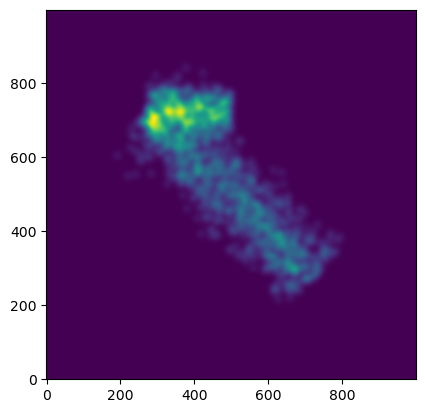

In [35]:
import sys
sys.path.append("../")
from cmap import find_bw

def build_grid(size=200):
    x_grid = np.linspace(-7, 7, size, endpoint=True)
    y_grid = np.linspace(-7, 7, size, endpoint=True)

    return np.stack(np.meshgrid(x_grid, y_grid, indexing="ij"), axis=-1)


sigma = 0.5

noise = np.random.randn(1000) * sigma

x1 = np.linspace(-np.pi, np.pi, 1000)
y1 = -x1.copy()


x1 += noise
y1 += noise

xy1 = np.stack([x1, y1], axis=-1)

x2 = np.linspace(0, np.pi, 500)
y2 = np.zeros_like(x2)

x2 -= np.pi
y2 += np.pi

noise = np.random.randn(500) * sigma

# x2 += noise
y2 += noise

xy2 = np.stack([x2, y2], axis=-1)

xy = np.concatenate([xy1, xy2])

N = 1000
grid = build_grid(N)

bw = find_bw(xy)
print(bw)

# scipy_kde = gaussian_kde(xy.T, bw_method="silverman")
# print(scipy_kde.silverman_factor())
fft_kde = FFTKDE(bw=bw)
fft_kde.fit(xy)
pdf = fft_kde.evaluate(grid.reshape(-1, 2)).reshape(N, N)
# pdf = scipy_kde.evaluate(grid.reshape(-1, 2).T).reshape(200, 200)


# plt.imshow(pdf, origin="lower")
plt.imshow(pdf.T, origin="lower")


In [3]:
def build_restype_inds_dict(resnames):
    out = {}

    for i, resname in enumerate(resnames):
        out.setdefault(resname, []).append(i)

    return {resname: np.array(inds) for resname, inds in out.items()}


In [8]:

runs_dir = Path("../runs")

ref_pdb = runs_dir / "cg.pdb"
ref_dir = runs_dir / "ref"

u = mda.Universe(ref_pdb, guess_bonds=True)

unique_restypes = set(u.residues.resnames.tolist())

traj_dirs =  list(ref_dir.glob("[0-9]*"))

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [ ]:
# angles = r.results.angles.transpose([1, 0, 2])
# restype_inds = build_restype_inds_dict(u.residues[1:-1].resnames)

# unique_restypes = set(res.name for res in traj.top.residues)

ratio = len(unique_restypes) / len(traj_dirs)

fig, axes = plt.subplots(
    nrows=len(unique_restypes), ncols=len(traj_dirs), figsize=(15, round(ratio * 15))
)

for ax in axes.flat:
    ax.axis("off")

for ax, d in zip(axes[0, :], traj_dirs, strict=True):
    ax.set_title(d.name)

for ax, resname in zip(axes[:, 0], unique_restypes, strict=True):
    ax.axis("on")
    ax.set_ylabel(resname)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["right", "left", "top", "bottom"]].set_visible(False)

for j, d in enumerate(traj_dirs):
    traj_file = d / "traj.xtc"

    traj = md.load(traj_file, top=ref_pdb)
    rama_angles = build_rama_angles(traj)

    grid = build_grid(rama_angles)

    resnames = [res.name for res in traj.top.residues][1:-1]
    restype_inds = build_restype_inds_dict(resnames)

    for i, (resname, inds) in enumerate(restype_inds.items()):
        ax = axes[i, j]

        restype_angles = rama_angles[inds].reshape(-1, 2)

        scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
        fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
        fft_kde.fit(restype_angles)
        pdf = fft_kde.evaluate(grid).reshape(200, 200)

        ax.imshow(pdf.T, origin="lower")

plt.tight_layout()

In [2]:
basepath = "/data/gzappavigna/lmp_conf_builder/runs/"
ens_traj = mdt.load(basepath + "ensemble.xtc", top=basepath + "cg.pdb")

basepath = "/data/gzappavigna/traj/a99sb-ildn_opc/"
# ref_traj = mdt.iterload(basepath + "step5_production_nojump.xtc", top=basepath + "step5_production_nojump.pdb")
ref_traj = mdt.load(basepath + "step5_production_nojump.xtc", top=basepath + "step5_production_nojump.pdb", stride=20)


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


In [3]:
import sys
sys.path.append("../")
from cmap import build_phipsi, build_cmap

ens_phipsi = build_phipsi(ens_traj)
ref_phipsi = build_phipsi(ref_traj)


ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (1600, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (1600, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (2000, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (2400, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (600, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (800, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (2800, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (2800, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (2400, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (800, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (1800, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (1400, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (1600, 2)
ens_rama_angles.shape: (130, 200, 2)
restype_angles.shape: (200, 2)
ens_rama_angles.shape: (130, 200, 2)
r

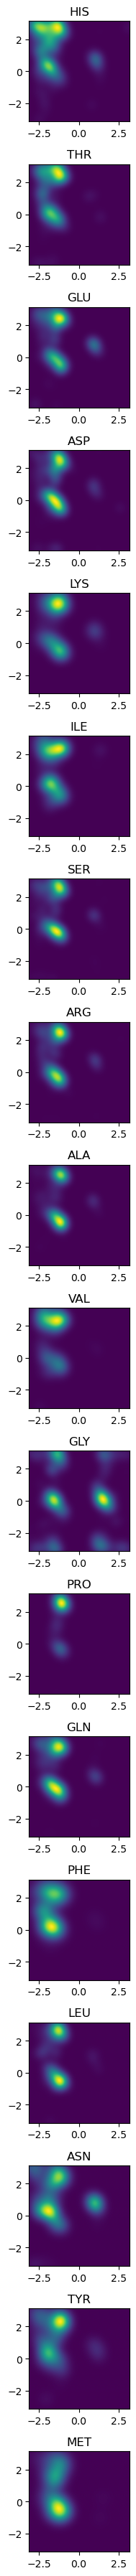

In [5]:

basepath = "/data/gzappavigna/lmp_conf_builder/runs/"
ens_traj = mdt.load(basepath + "ensemble.xtc", top=basepath + "cg.pdb")


# ens_traj = md.load(ens_traj_path, top="/data/gzappavigna/lmp_conf_builder/runs/cg.pdb")
# ens_traj = md.load(ens_traj_path, top="/data/gzappavigna/lmp_conf_builder/ensemble/5064a_132.pdb")
# ens_rama_angles = build_rama_angles(ens_traj)
# grid = build_grid(ens_rama_angles)

unique_restypes = set(res.name for res in ens_traj.top.residues)
fig, axes = plt.subplots(nrows=len(unique_restypes), ncols=1, figsize=(2, 2 * len(unique_restypes)))

resnames = [res.name for res in ens_traj.top.residues][1:-1]
restype_inds = build_restype_inds_dict(resnames)

for i,  (resname, inds) in enumerate(restype_inds.items()):
    ax = axes[i]

    print("ens_rama_angles.shape:", ens_rama_angles.shape)
    restype_angles = ens_rama_angles[inds].reshape(-1, 2)
    print("restype_angles.shape:", restype_angles.shape)

    scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
    fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
    fft_kde.fit(restype_angles)
    pdf = fft_kde.evaluate(grid).reshape(200, 200)
    # pdf = scipy_kde.evaluate(points.T).reshape(200, 200)

    ax.imshow(pdf.T, origin='lower', extent=[grid[:, 0].min(), grid[:, 0].max(), grid[:, 1].min(), grid[:, 1].max()])
    ax.set_title(resname)

plt.tight_layout()

1
0.2
0.4
2
0.2
0.4
3
0.2
0.4
4
0.2
0.4
5
0.2
0.4
6
0.2
0.4
7
0.2
0.4
8
0.2
0.4
9
0.2
0.4
10
0.2
0.4
11
0.2
0.4
12
0.2
0.4
13
0.2
0.4
14
0.2
0.4
15
0.2
0.4
16
0.2
0.4
17
0.2
0.4
18
0.2
0.4
19
0.2
0.4
20
0.2
0.4
21
0.2
0.4
22
0.2
0.4
23
0.2
0.4
24
0.2
0.4
25
0.2
0.4
26
0.2
0.4
27
0.2
0.4
28
0.2
0.4
29
0.2
0.4
30
0.2
0.4
31
0.2
0.4
32
0.2
0.4
33
0.2
0.4
34
0.2
0.4
35
0.2
0.4
36
0.2
0.4
37
0.2
0.4
38
0.2
0.4
39
0.2
0.4
40
0.2
0.4
41
0.2
0.4
42
0.2
0.4
43
0.2
0.4
44
0.2
0.4
45
0.2
0.4
46
0.2
0.4
47
0.2
0.4
48
0.2
0.4
49
0.2
0.4
50
0.2
0.4
51
0.2
0.4
52
0.2
0.4
53
0.2
0.4
54
0.2
0.4
55
0.2
0.4
56
0.2
0.4
57
0.2
0.4
58
0.2
0.4
59
0.2
0.4
60
0.2
0.4
61
0.2
0.4
62
0.2
0.4
63
0.2
0.4
64
0.2
0.4
65
0.2
0.4
66
0.2
0.4
67
0.2
0.4
68
0.2
0.4
69
0.2
0.4
70
0.2
0.4
71
0.2
0.4
72
0.2
0.4
73
0.2
0.4
74
0.2
0.4
75
0.2
0.4
76
0.2
0.4
77
0.2
0.4
78
0.2
0.4
79
0.2
0.4
80
0.2
0.4
81
0.2
0.4
82
0.2
0.4
83
0.2
0.4
84
0.2
0.4
85
0.2
0.4
86
0.2
0.4
87
0.2
0.4
88
0.2
0.4
89
0.2
0.4
90
0.2
0.4
91
0.2
0.4
92
0.2
0

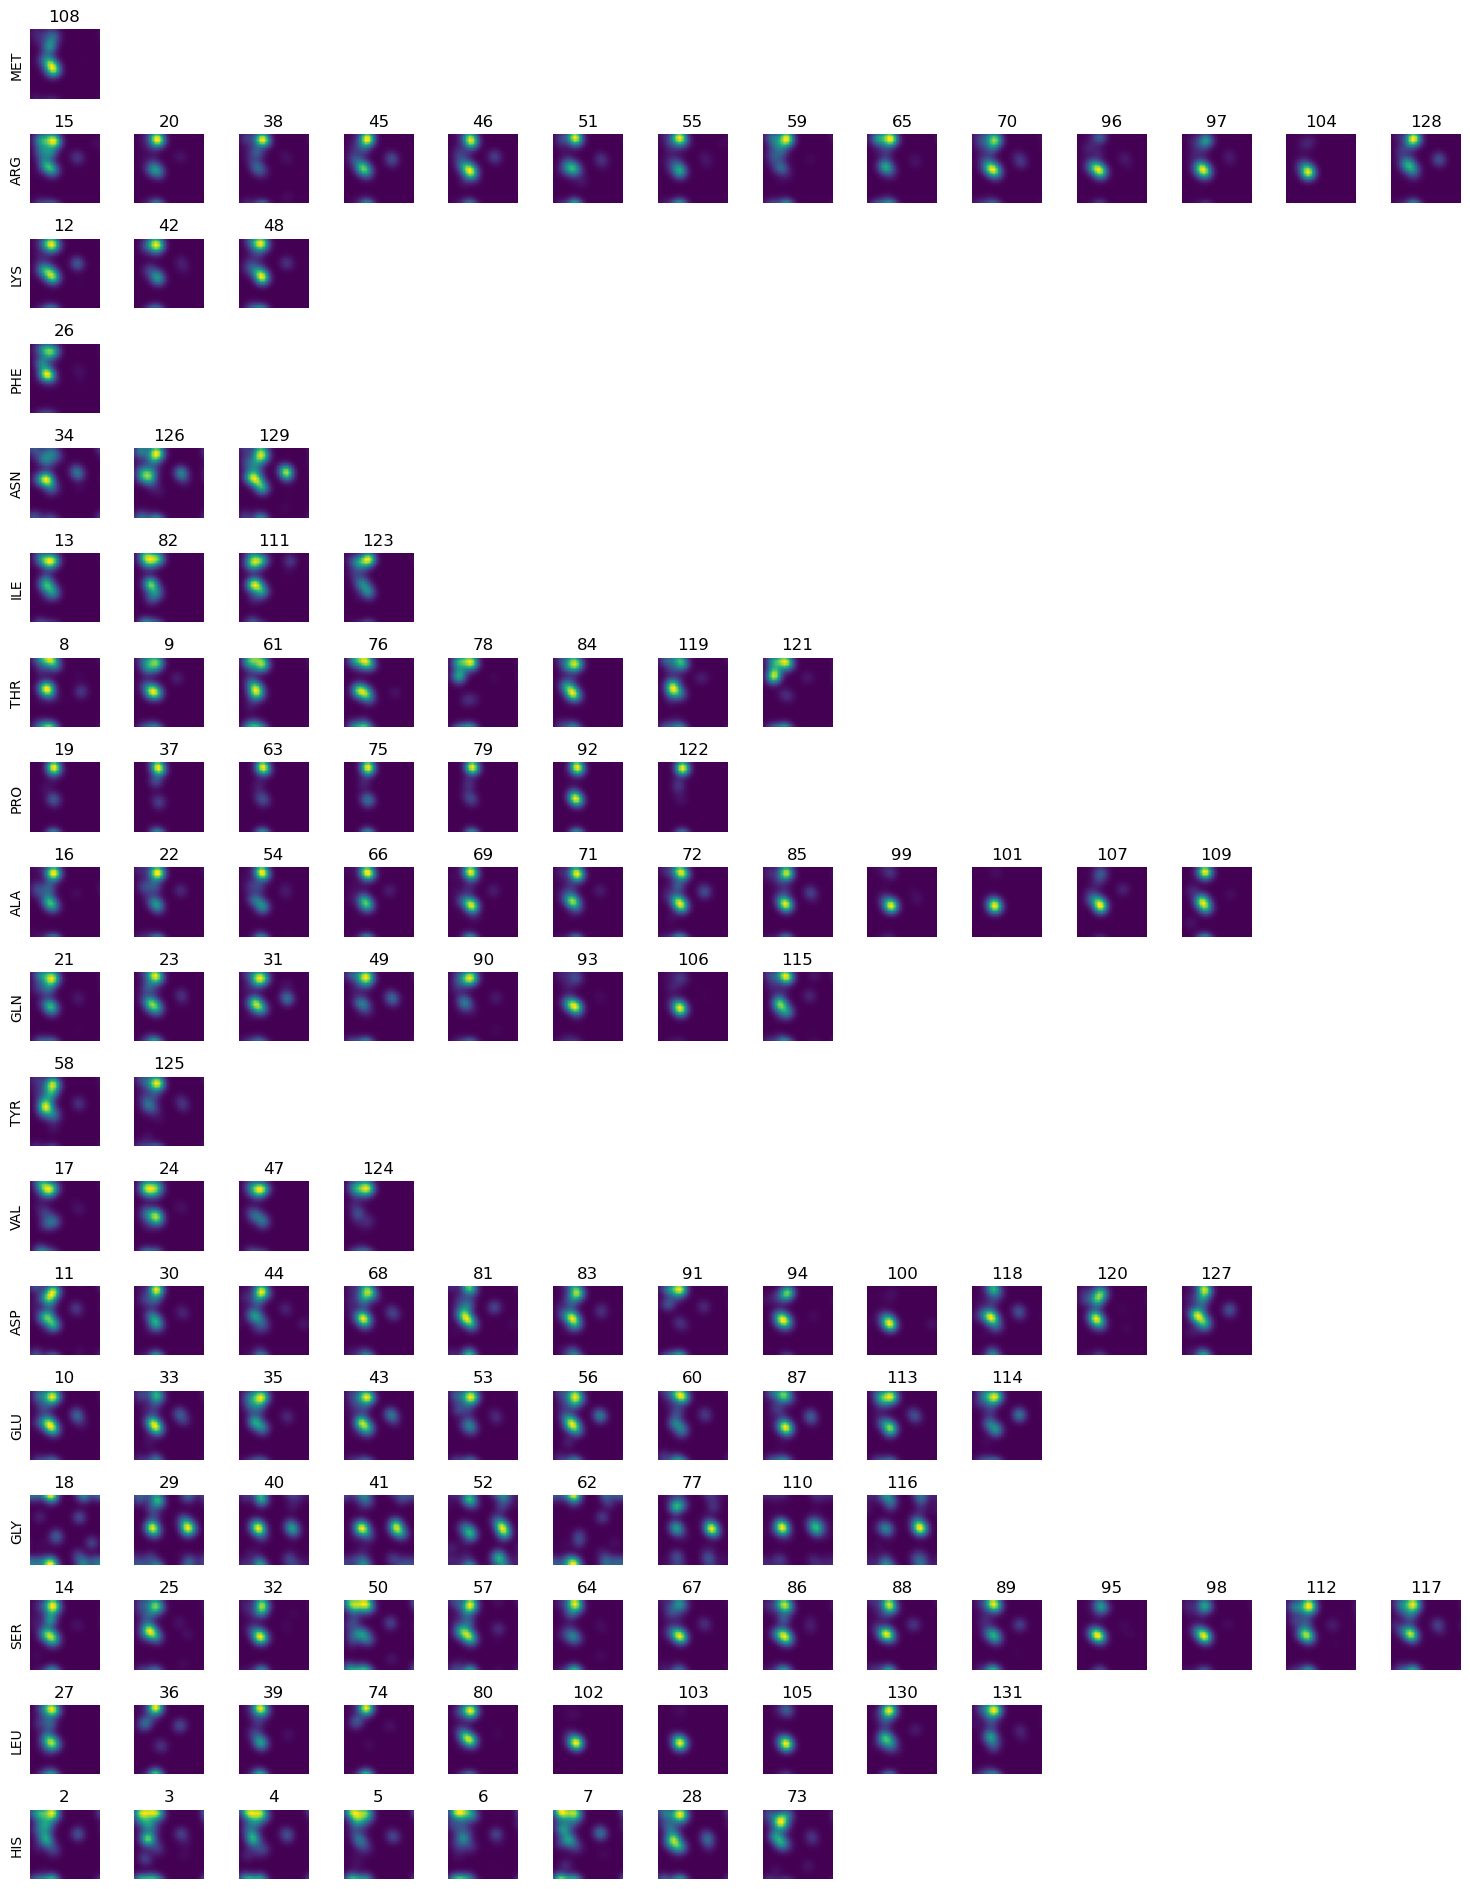

In [5]:
from collections import Counter

# ens_traj_path = "/data/gzappavigna/lmp_conf_builder/runs/6921a_132/cmap/traj.xtc"
# ens_traj_path = "/data/gzappavigna/lmp_conf_builder/runs/ensemble.xtc"
# ens_traj_path = "/data/gzappavigna/lmp_conf_builder/ensemble/ensemble.xtc"

# ens_traj = md.load(ens_traj_path, top="/data/gzappavigna/lmp_conf_builder/ensemble/5064a_132_CG.pdb")
# ens_traj = md.load(ens_traj_path, top="/data/gzappavigna/lmp_conf_builder/runs/cg.pdb")
# ens_traj = next(md.iterload(ens_traj_path, 100_000, top="/data/gzappavigna/lmp_conf_builder/runs/cg.pdb"))
# ens_rama_angles = build_rama_angles(ens_traj)
# grid = build_grid(ens_rama_angles)

unique_restypes = set(res.name for res in ens_traj.topology.residues)

residues = list(ens_traj.top.residues)[1:-1]
#resnames = [res.name for res in ens_traj.top.residues][1:-1]
c = Counter(map(lambda res: res.name, residues))
[(_, max_count)] =  c.most_common(1)

ratio = len(unique_restypes) / max_count
fig, axes = plt.subplots(nrows=len(unique_restypes), ncols=max_count, figsize=(15, round(15 * ratio)))

for ax in axes.flat:
    ax.axis("off")

for ax, resname in zip(axes[:, 0], unique_restypes, strict=True):
    ax.axis("on")
    ax.set_ylabel(resname)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["right", "left", "top", "bottom"]].set_visible(False)

ax_its = {resname: iter(row) for resname, row in zip(unique_restypes, axes, strict=True)}

for res in residues:
    print(res.index)
    ax = next(ax_its[res.name])
    # restype_angles = ens_rama_angles[i]

    sel_ens_phipsi = ens_phipsi[res.index]
    sel_ref_phipsi = ref_phipsi[res.index]

    cmap, ens_pdf, _, _ = build_cmap(sel_ens_phipsi, sel_ref_phipsi, ens_bw=0.4, ref_bw=0.2)

    # scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
    # print(scipy_kde.silverman_factor())
    # print(scipy_kde.scotts_factor())
    # fft_kde = FFTKDE(bw=0.15)
    # fft_kde = FFTKDE()
    # fft_kde.fit(restype_angles)
    # pdf = fft_kde.evaluate(grid).reshape(200, 200)

    ax.imshow(ens_pdf.T, origin="lower")
    # if resname in {"GLY", "PRO", "ALA"}:
    #     neigh = "-".join(resnames[i-1:i+2])
    #     ax.set_title(f"{i+1}: {neigh}", fontsize=8)
    # else:
    ax.set_title(res.resSeq)


for ax_it in ax_its.values():
    for ax in ax_it:
        fig.delaxes(ax)

plt.tight_layout()

In [1]:
traj_path = "/data/nsalvi/NT_HPS/test_4BR/ref_20210817/1/nopbc.dcd"
traj = md.load(traj_path, top="/data/nsalvi/NT_HPS/test_4BR/ref_20210817/1/CG.pdb")

unique_restypes = set(res.name for res in traj.top.residues)

rama_angles = build_rama_angles(traj)
grid = build_grid(rama_angles)

fig, axes = plt.subplots(nrows=len(unique_restypes), ncols=1, figsize=(2, 2 * len(unique_restypes)))

resnames = [res.name for res in traj.top.residues][1:-1]
restype_inds = build_restype_inds_dict(resnames)

for i,  (resname, inds) in enumerate(restype_inds.items()):
    ax = axes[i]

    restype_angles = rama_angles[inds].reshape(-1, 2)

    scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
    fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
    fft_kde.fit(restype_angles)
    pdf = fft_kde.evaluate(grid).reshape(200, 200)
    # pdf = scipy_kde.evaluate(points.T).reshape(200, 200)

    ax.imshow(pdf.T, origin="lower")
    ax.axis("off")
    ax.set_title(resname)

plt.tight_layout()


NameError: name 'md' is not defined